![RFCAN](logo.png "RFCAN_LOGO")

In [ ]:
from codes_RF.prep import PREP

box = [55, 85, -105, -75]
radius =[30, 100]
mag = [5.5, 10.0]
events = [2000, 2030]
year = 3 #years of data

In [ ]:
PREP.preparation(box, radius, mag, events, year, verbose=False)

### Downloading RAW_WFs

To minimize the time spent on downloading from NRCAN, you have the option to specify which networks you want to download from their web server. Simply set nrcan=True to activate downloading from this source.
```
DL.comprehensive_download(NET1, NET2, ..., nrcan=True)
```



In [ ]:
from codes_RF.prep import DL
DL.comprehensive_download("X5","PO", nrcan=True)

### Creating RFs

In [ ]:
from codes_RF.prep import RF
list = RF.mk_rf(filters=[0.05,0.5])

### Manual QC

you can analyze your data set by filtering some part and look at the results

In [ ]:
from codes_RF.prep import QC
QC.preview(filters=["sta_code-eq-TQF","rf_quality-eq-1"], data_type="rf", preview_type="plot")

here you can do QC by examining the RFs and the corresponding RAW_WFs one-on-one

In [ ]:
from codes_RF.prep import QC
QC.manual_quality()

### Automatic QC by DeepQCRF

Doing QC using DeepQCRF is also possible, and you just need to use the following command and also filter your dataset by test_set_keywords:


In [ ]:
from codes_RF.prep import QC

test_set_keywords = ["net_code-eq-X5", "ev_mag-gt-5.0"]
new_df = QC.quality_pred(test_set_keywords)

### Visualizing RFs

Setting your input stations and the bin size for the RFs

In [141]:
from codes_RF.viz import viz
import pandas as pd

sta_list = list(pd.read_csv("inv/all_stations.csv")["sta_code"])
print(sta_list)
sta_list = ['RES']

hist_bin = 20

['AKVQ', 'AP3N', 'ARVN', 'AXF', 'BLKN', 'BULN', 'CNF', 'CRLN', 'CTSN', 'DORN', 'EUNU', 'FCC', 'GIFN', 'IBFB', 'IGLN', 'ILON', 'INUQ', 'JOSN', 'KJKQ', 'KUGN', 'LAIN', 'MANN', 'MARN', 'MCF', 'MCMN', 'MRYN', 'NOTN', 'NUNN', 'POIN', 'QILN', 'RES', 'SAKN', 'SEDN', 'SHMN', 'SHWN', 'SMLN', 'SNKN', 'SRLN', 'STLN', 'TQF', 'WAGN', 'YRTN']


Dataframe has been updated
slow and baz have been added to the dataframe
Plotting the histogram of baz for each station ...
Number of waveforms for RES is 20


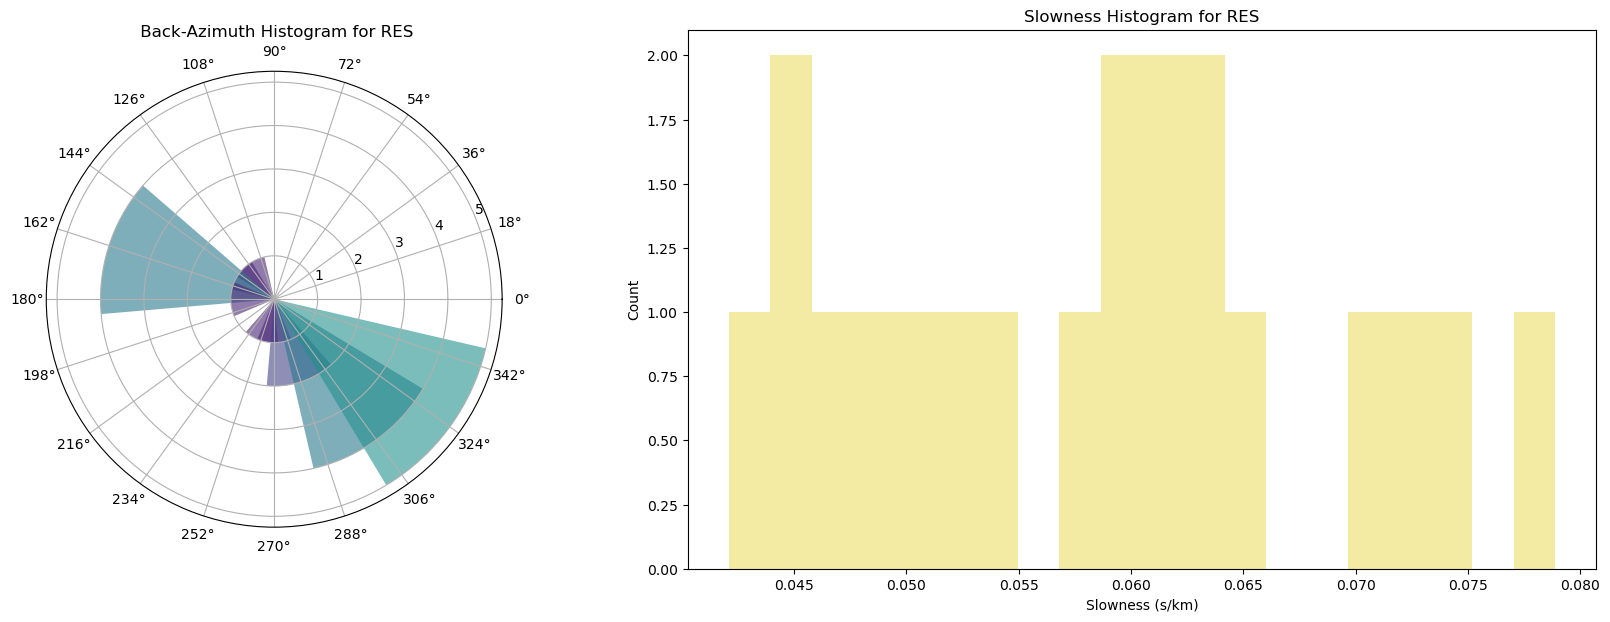

Plotting the slow section for each station ...


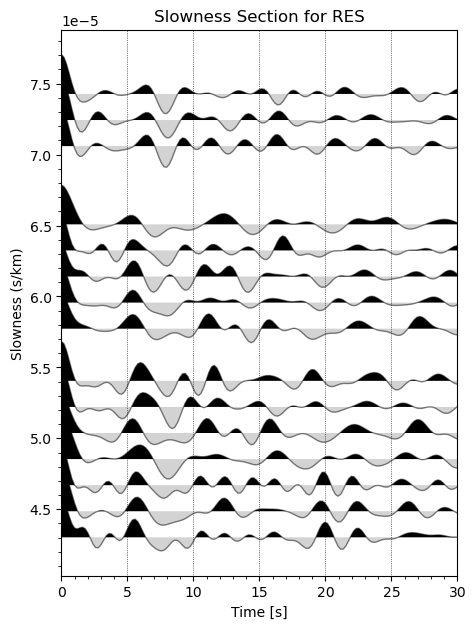

Plotting the baz section for each station ...


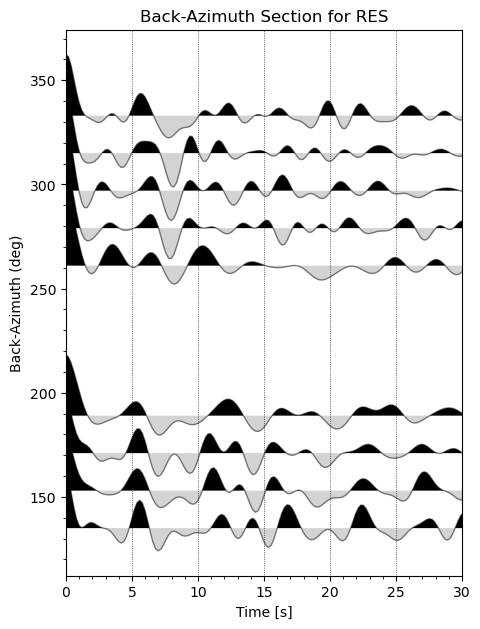

In [142]:
my_proj = viz(sta_list, hist_bin, using_pred=True)   #create a viz object
my_proj.distribution_hist()         #plot distribution histogram for baz and slow
my_proj.plot_section(type="slow")   #plot section for slow
my_proj.plot_section(type="baz")    #plot section for baz

## H-k Stacking

! below station ILON is in both CN and PO networks, so it uses both networks to stack the 

I removed station **AKVQ** from the list cause there is only two waveforms for this station

['CRLN', 'CTSN', 'MANN', 'MARN', 'DORN', 'NOTN', 'SHWN', 'SHMN']
CRLN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 39
Computing: [###############] 151/151


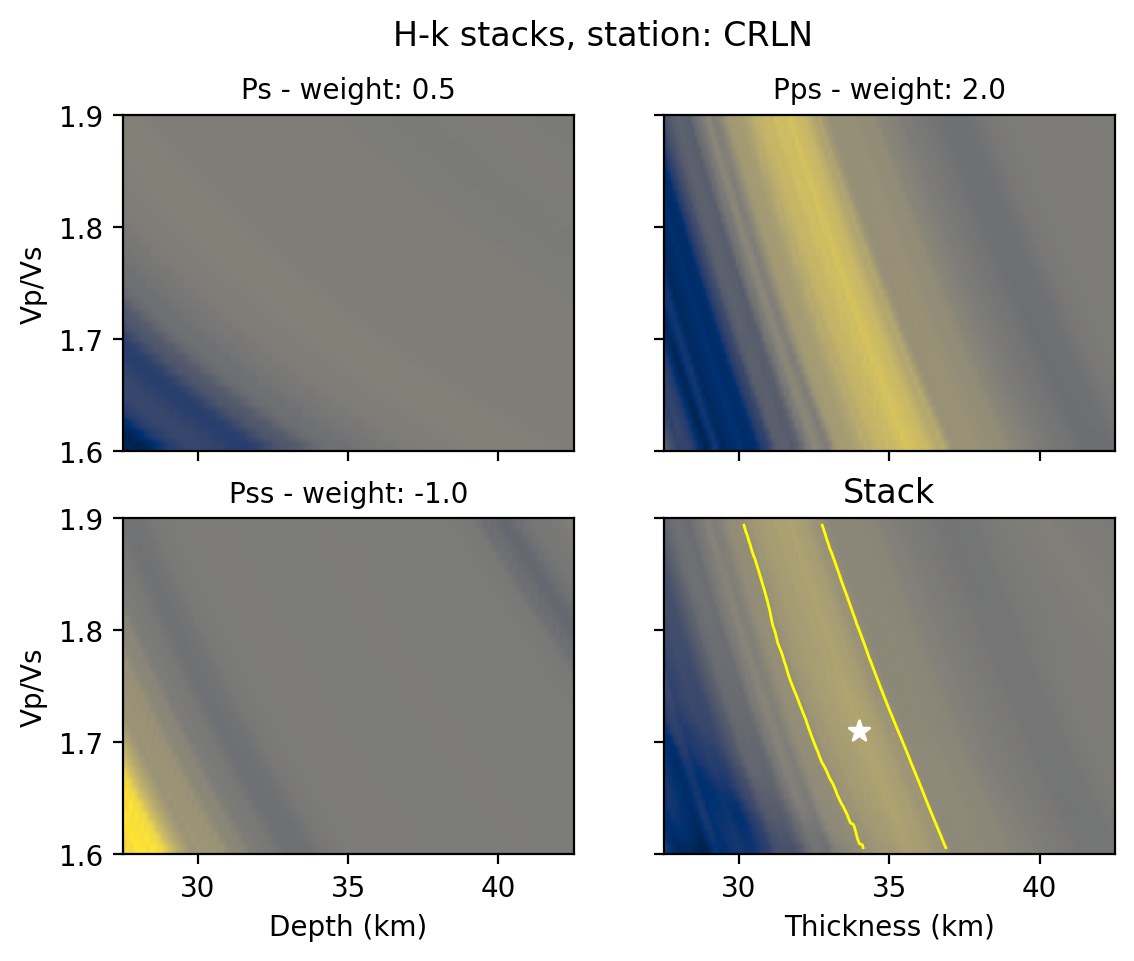

Current h0: 34.0 -- Current k0: 1.71 -- Current h_err: 1.675 -- Current k_err: 0.075
------------------------------------------------------------
------------------------------------------------------------
CTSN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 50
Computing: [###############] 151/151


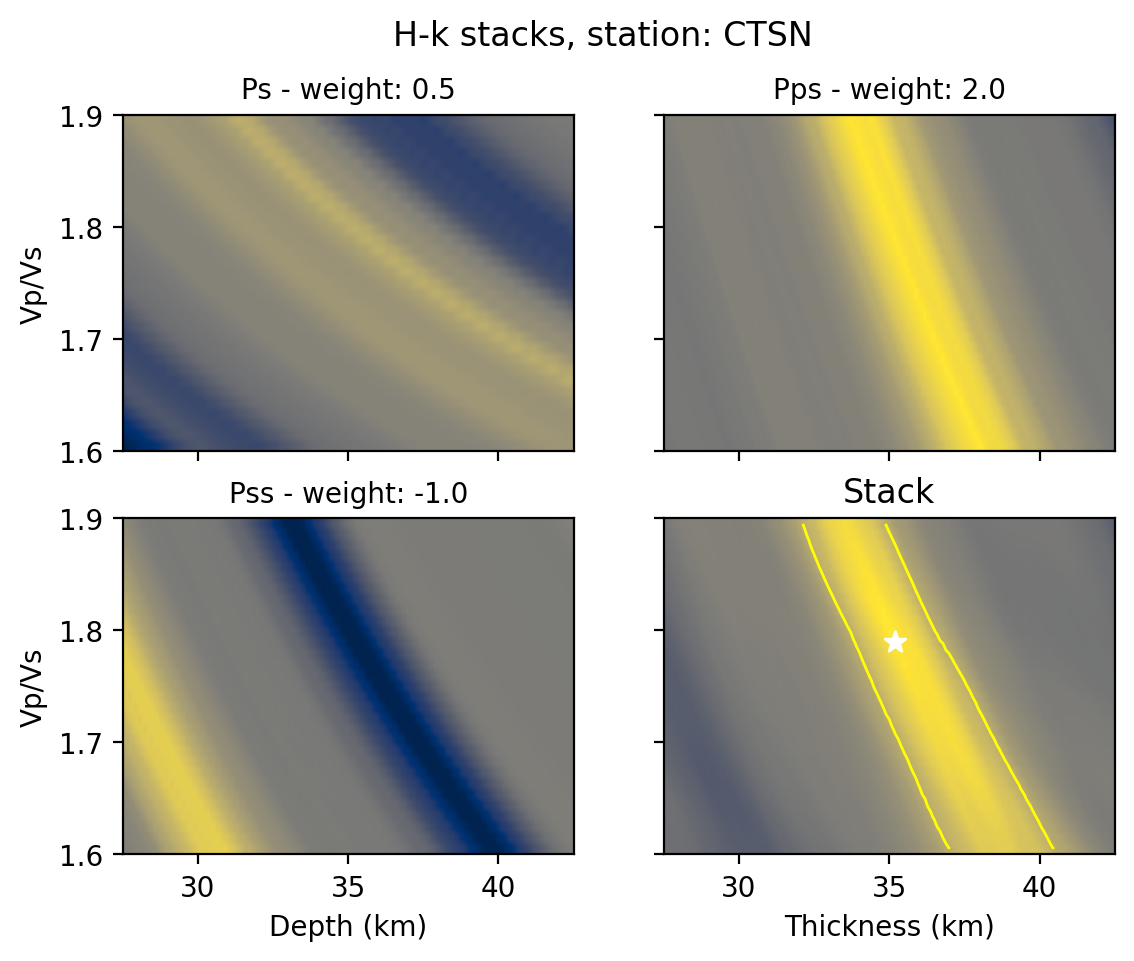

Current h0: 35.2 -- Current k0: 1.79 -- Current h_err: 2.075 -- Current k_err: 0.075
------------------------------------------------------------
------------------------------------------------------------
MANN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 43
Computing: [###############] 151/151


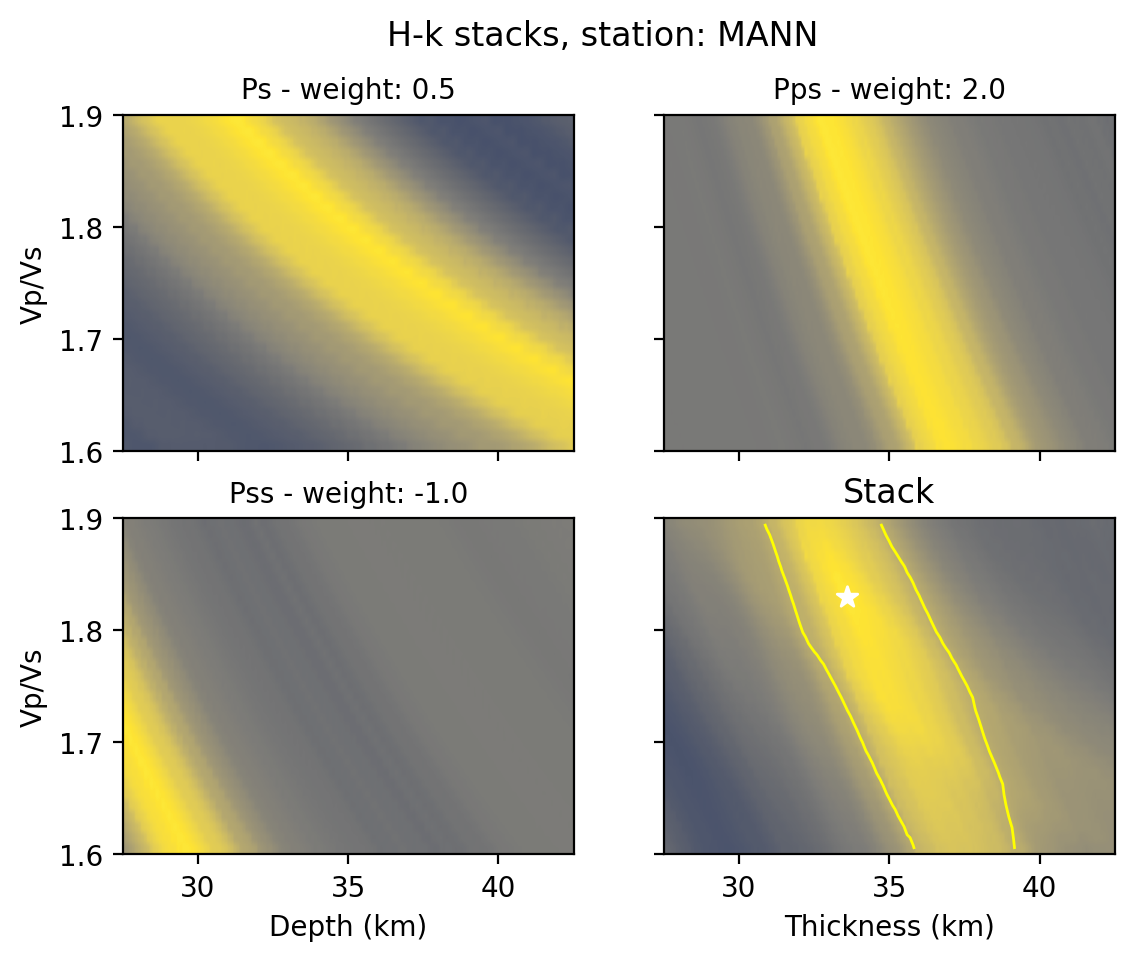

Current h0: 33.6 -- Current k0: 1.83 -- Current h_err: 2.075 -- Current k_err: 0.075
------------------------------------------------------------
------------------------------------------------------------
MARN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 49
Computing: [###############] 151/151


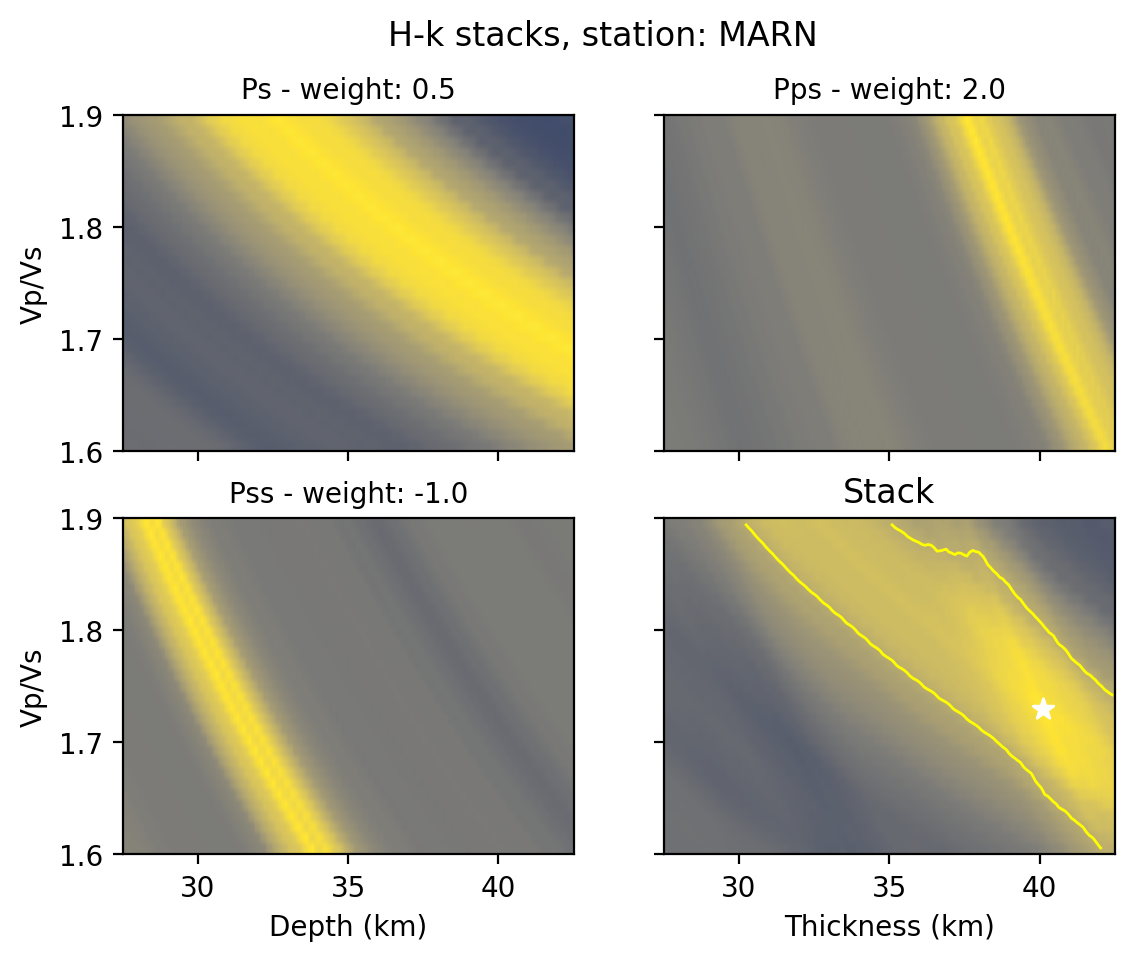

Current h0: 40.1 -- Current k0: 1.73 -- Current h_err: 3.075 -- Current k_err: 0.075
------------------------------------------------------------
------------------------------------------------------------
DORN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 83
Computing: [###############] 151/151


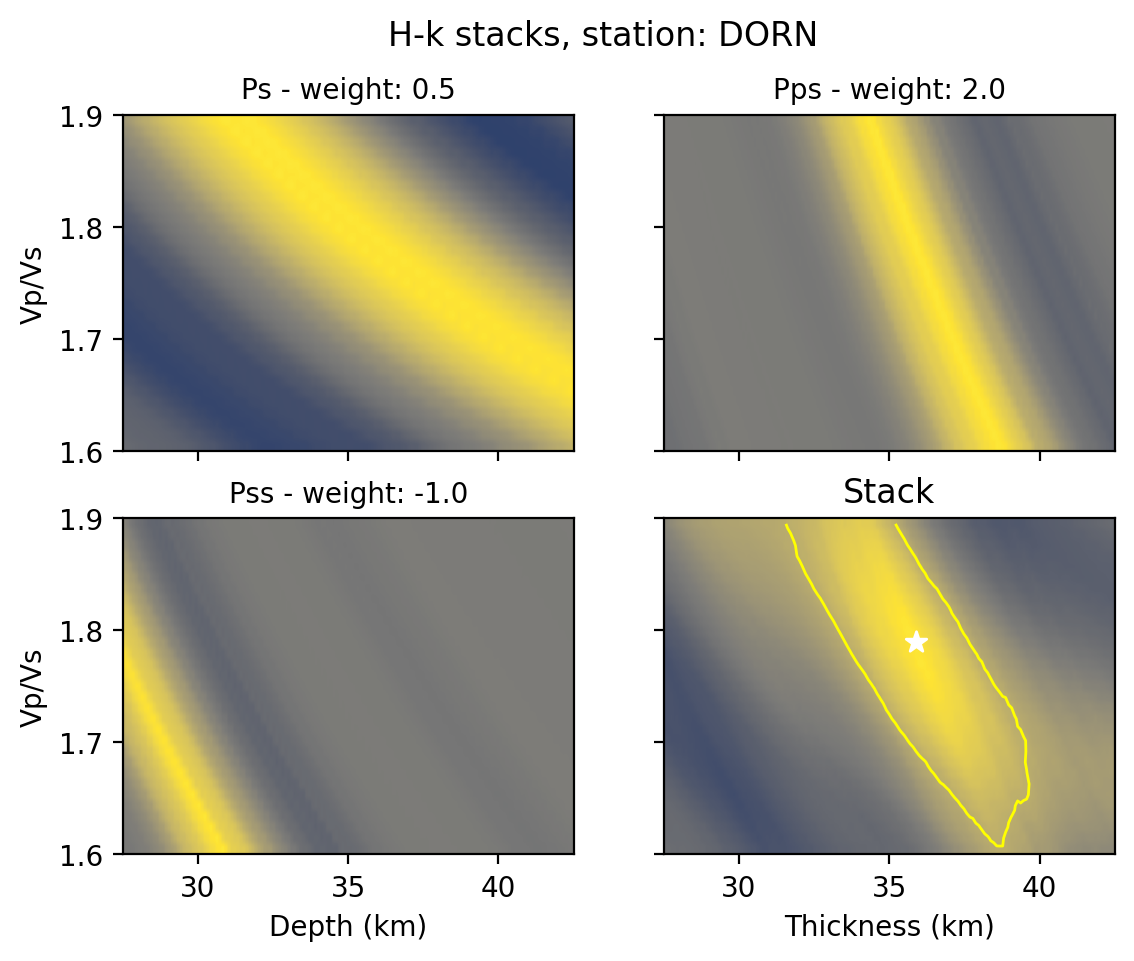

Current h0: 35.9 -- Current k0: 1.79 -- Current h_err: 2.0 -- Current k_err: 0.073
------------------------------------------------------------
------------------------------------------------------------
NOTN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 45
Computing: [###############] 151/151


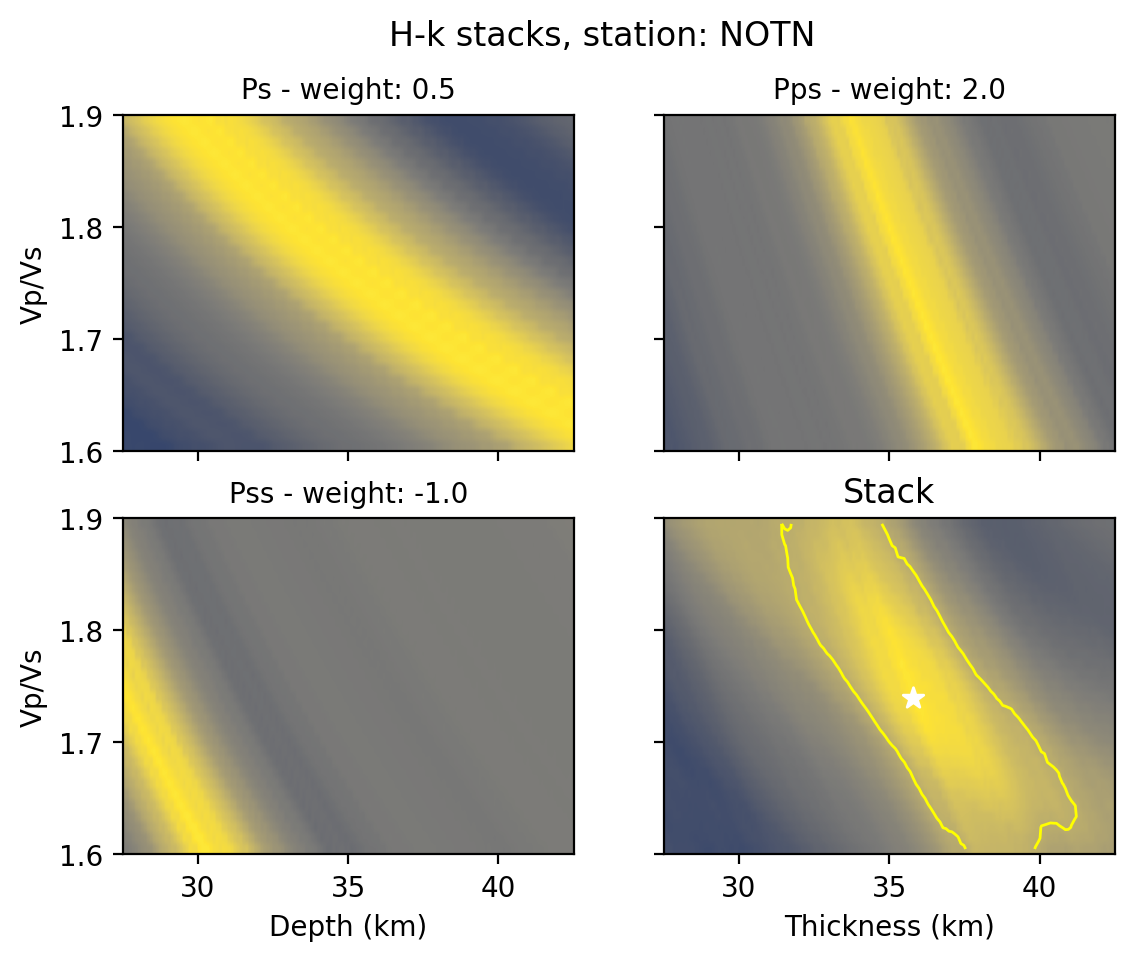

Current h0: 35.8 -- Current k0: 1.74 -- Current h_err: 2.45 -- Current k_err: 0.075
------------------------------------------------------------
------------------------------------------------------------
SHWN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 40
Computing: [###############] 151/151


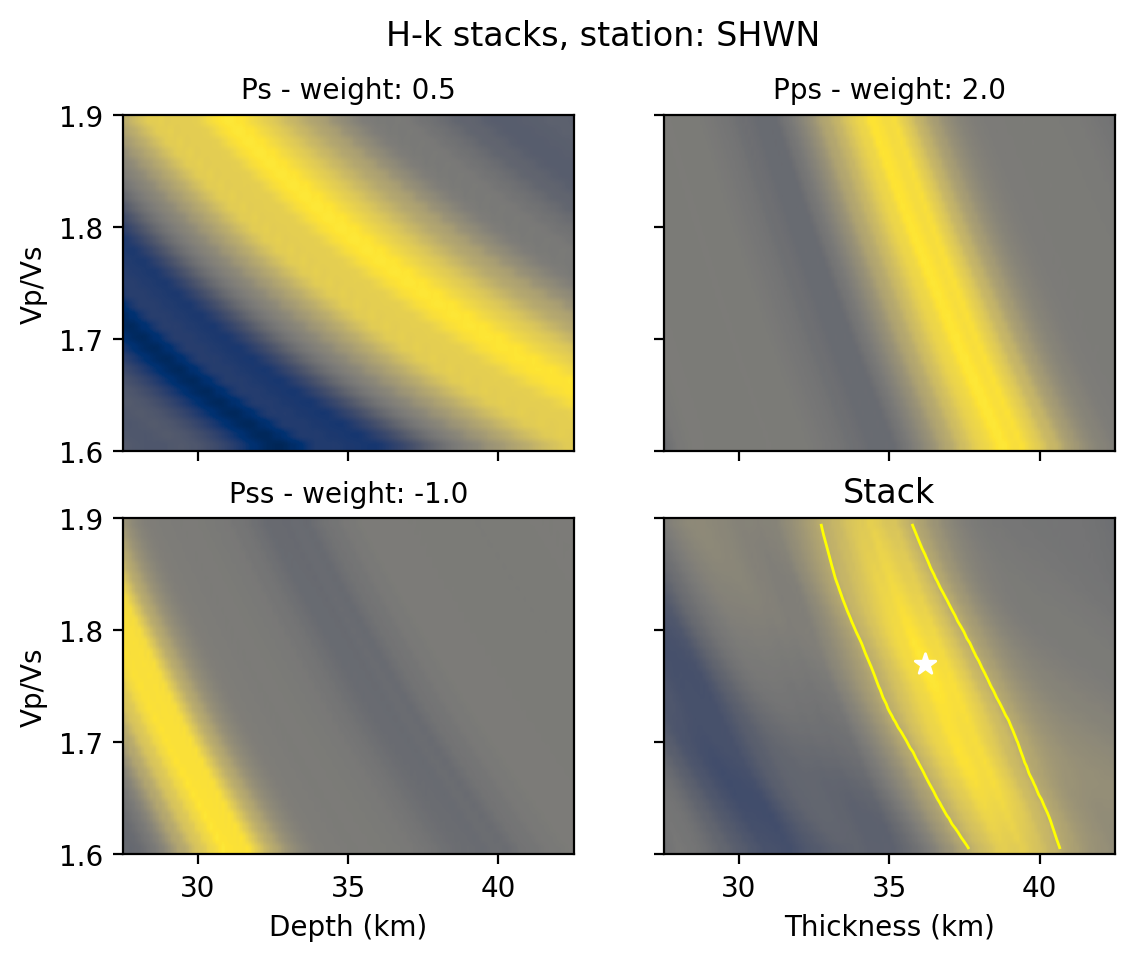

Current h0: 36.2 -- Current k0: 1.77 -- Current h_err: 1.975 -- Current k_err: 0.075
------------------------------------------------------------
------------------------------------------------------------
SHMN ++++++++++++++++++++++++++++++++++++++++++++++
Number of traces: 42
Computing: [###############] 151/151


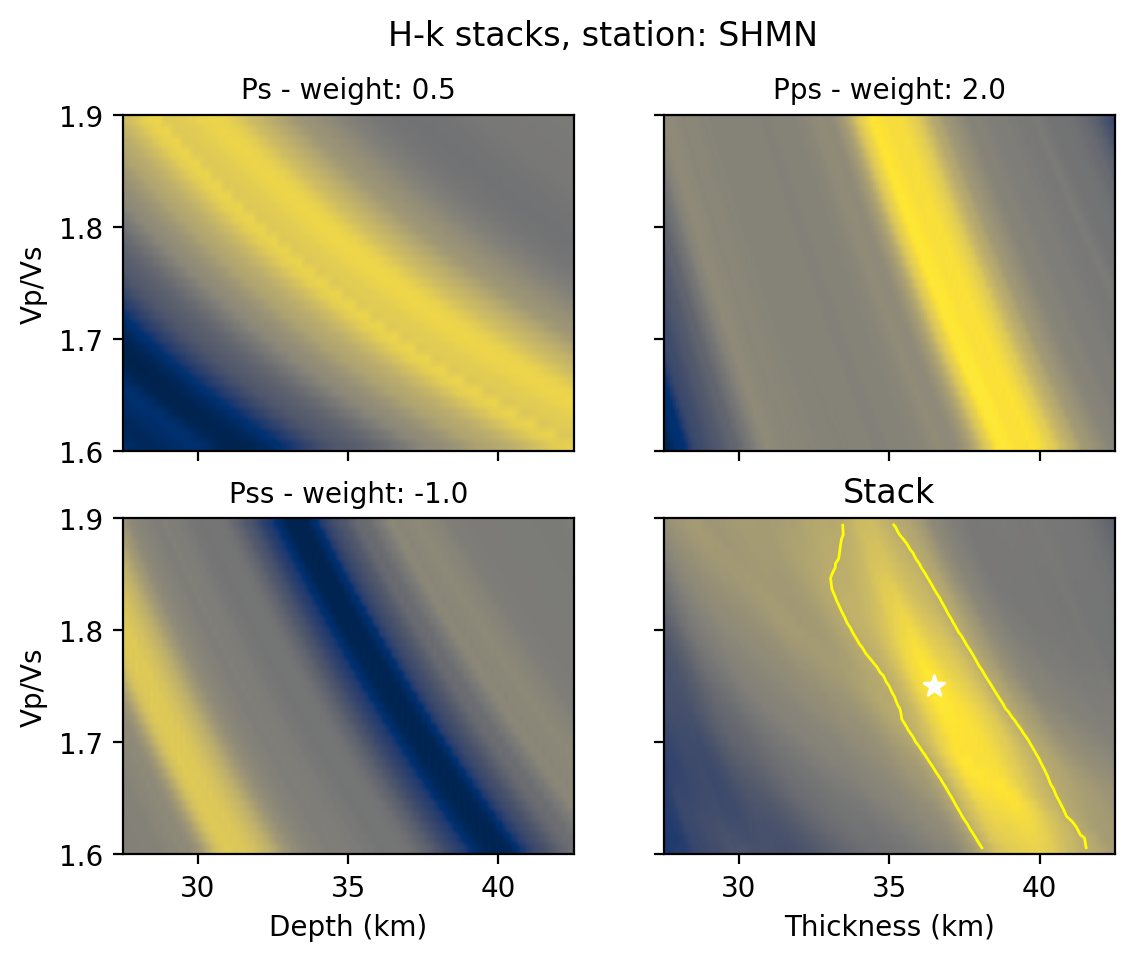

Current h0: 36.5 -- Current k0: 1.75 -- Current h_err: 2.125 -- Current k_err: 0.075
------------------------------------------------------------
------------------------------------------------------------


In [2]:
from codes_RF.hk import HKCan

path_file = "DATA/waveforms_list.csv"

#temp#temp#temp
import numpy as np
import pandas as pd
stations = pd.read_csv(path_file)["sta_code"].unique()
stations = np.array(stations)
stations = np.sort(stations)
stations = np.delete(stations, np.where(stations == "AKVQ"))
stations = np.delete(stations, np.where(stations == "SNKN"))
stations = np.delete(stations, np.where(stations == "KJKQ"))
stations = np.delete(stations, np.where(stations == "MRYN"))
stations = np.delete(stations, np.where(stations == "IVKQ"))
#TEMPORARY STATIONS
stations = ["CRLN","CTSN",'MANN',"MARN", "DORN", "NOTN", "SHWN", "SHMN"]
print(stations)

for sta in stations:
    print(sta, "++++++++++++++++++++++++++++++++++++++++++++++")
    hkcan = HKCan(path_file, sta, weights=[.5, 2., -1.])#weights=weights[stations.index(sta)])
    hkcan.hk(vp=6.5)
    # hkcan.hk_change_param(weights=[3,1,-1], plot=True, auto_optimization=True)   #weights[stations.index(sta)], plot=True, auto_optimization=True)
    

==================== RES ====================

Decomposing receiver functions into baz harmonics
harmonics.azim = 278.0
Number of events = 20


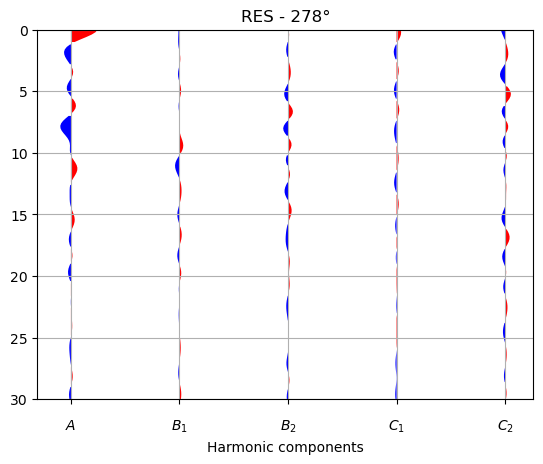

In [144]:
from codes_RF.rfpy_pkg.harmonics import Harmonics
import pandas as pd
import obspy


# # stations = ["SHWN", "SHMN", "MARN", "MANN", "DORN", "NOTN", "CRLN", "CTSN"]
# # stations = ["SHWN", "SHMN", "MARN", "MANN", "DORN", "NOTN", "CRLN", "CTSN", "AXF", "CNF", "IBFB", "IBFE", "TQF", "MISB1", "MISB2", "PVB1", "PVB2", "BLKN", "EUNU", "FCC", "ILON", "POIN", "RES", "SAKN", "AKVQ", "AP3N", "ARVN", "BULN", "GIFN", "IGLN", "INUQ", "IVKQ", "JSON", "KUGN", "LAIN", "MCMN", "MRYN", "NUNN", "QILN", "SEDN", "SMLN", "SNKN", "SNQN", "SRLN", "STLN", "WAGN", "YBKN", "YRTN"]
# stations = pd.read_csv("DATA/waveforms_list.csv")["sta_code"].unique()

#temp#temp#temp
import numpy as np
# stations = np.delete(stations, np.where(stations == "AKVQ"))
# stations = np.delete(stations, np.where(stations == "SNKN"))
# stations = np.delete(stations, np.where(stations == "KJKQ"))
# stations = np.delete(stations, np.where(stations == "MRYN"))
stations = ['RES']


for sta in stations:

    print(f"==================== {sta} ====================")
    list_df = pd.read_csv("DATA/waveforms_list.csv")
    list_sta = list_df[(list_df.sta_code == sta) & (list_df.rf_quality == 1)]

    #reading all waveforms R and T
    rfR = obspy.Stream()
    rfT = obspy.Stream()

    for i in range(len(list_sta)):
        file_name = list_sta.file_name.iloc[i]
        path = f"DATA/RF/{file_name}.pkl"
        wf = obspy.read(path)
        rfR += wf.select(channel = "RFR")
        rfT += wf.select(channel = "RFT")

    rfR.filter('bandpass', freqmin = 0.05, freqmax = 0.5, corners = 4, zerophase = True)
    rfT.filter('bandpass', freqmin = 0.05, freqmax = 0.5, corners = 4, zerophase = True)

    harmonics = Harmonics(rfR, rfT)


    harmonics.dcomp_find_azim()

    print(f"{harmonics.azim = }")
    print(f"Number of events = {len(list_sta)}")

    harmonics.plot(scale = 4, title=f"{sta} - {harmonics.azim:.0f}°")

In [ ]:
# harmonics.forward(baz_list=[10, 20, 30, 348])
# import matplotlib.pyplot as plt
# for tr in harmonics.radial_forward:
#     tr.plot()
#     plt.show()